##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用预处理随机梯度朗格文动力学拟合狄利克雷过程混合模型

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/probability/examples/Fitting_DPMM_Using_pSGLD"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

在此笔记本中，我们将演示如何通过拟合高斯分布的狄利克雷过程混合来聚类大量样本并同时推断簇的数量。我们使用预处理随机梯度朗格文动力学 (pSGLD) 进行推断。 

## 目录

1. 样本

2. 模型

3. 优化

4. 呈现结果

4.1. 聚类结果

4.2. 呈现不确定度

4.3. 所选混合分量的平均值和尺度

4.4. 每个混合分量的混合权重

4.5. $\alpha$ 的收敛

4.6. 迭代中的推断簇数量

4.7. 使用 RMSProp 拟合模型

1. 结论

---


## 1. 样本

首先，设置一个小数据集。我们从三个双变量高斯分布中生成 50,000 个随机样本。

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

In [ ]:
plt.style.use('ggplot')
tfd = tfp.distributions

In [ ]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

In [ ]:
# For reproducibility
rng = np.random.RandomState(seed=45)
tf.set_random_seed(76)

# Precision
dtype = np.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]
                + rng.randn(num_samples, dims).astype(dtype))

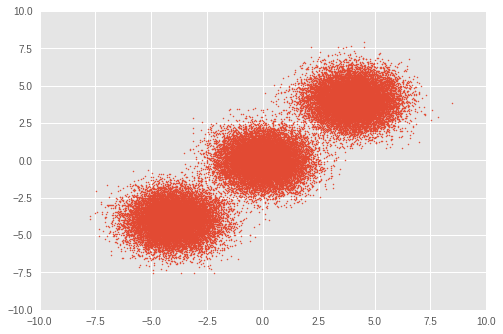

In [ ]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

## 2. 模型

在这里，我们定义一个具有对称狄利克雷先验的高斯分布的狄利克雷过程混合。在整个笔记本中，向量以粗体显示。在 $i\in{1,\ldots,N}$ 样本上，具有 $j \in{1,\ldots,K}$ 高斯分布混合的模型可用以下公式表示：

$$\begin{align*} p(\boldsymbol{x}*1,\cdots, \boldsymbol{x}*N) &amp;=\prod*{i=1}^N \text{GMM}(x_i), \ &amp;,\quad \text{其中};\text{GMM}(x_i)=\sum*{j=1}^K\pi_j\text{Normal}(x_i,|,\text{loc}=\boldsymbol{\mu_{j}},,\text{scale}=\boldsymbol{\sigma_{j}})\ \end{align*}$$ 其中：

$$\begin{align*} x_i&amp;\sim \text{Normal}(\text{loc}=\boldsymbol{\mu}*{z_i},,\text{scale}=\boldsymbol{\sigma}*{z_i}) \ z_i &amp;= \text{Categorical}(\text{prob}=\boldsymbol{\pi}),\ &amp;,\quad \text{其中};\boldsymbol{\pi}={\pi_1,\cdots,\pi_K}\ \boldsymbol{\pi}&amp;\sim\text{Dirichlet}(\text{concentration}={\frac{\alpha}{K},\cdots,\frac{\alpha}{K}})\ \alpha&amp;\sim \text{InverseGamma}(\text{concentration}=1,,\text{rate}=1)\ \boldsymbol{\mu_j} &amp;\sim \text{Normal}(\text{loc}=\boldsymbol{0}, ,\text{scale}=\boldsymbol{1})\ \boldsymbol{\sigma_j} &amp;\sim \text{InverseGamma}(\text{concentration}=\boldsymbol{1},,\text{rate}=\boldsymbol{1})\ \end{align*}$$

我们的目标是通过表示推断的簇索引的 $z_i$ 将每个 $x_i$ 分配给第 $j$ 个簇。

对于理想的狄利克雷混合模型，$K$ 会被设置为 $\infty$。不过，众所周知，我们可以用一个足够大的 $K$ 来估算狄利克雷混合模型。请注意，尽管我们随意设置了 $K$ 的初始值，但与简单的高斯混合模型不同，可以通过优化推断最佳簇数量。

在此笔记本中，我们使用双变量高斯分布作为混合分量，并将 $K$ 设置为 30。

In [ ]:
reset_sess()

# Upperbound on K
max_cluster_num = 30

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.Variable(
        name='mix_probs',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc = tf.Variable(
    name='loc',
    initial_value=np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision = tf.nn.softplus(tf.Variable(
    name='precision',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.Variable(
    name='alpha',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype) * alpha / max_cluster_num,
    name='rv_sdp')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))

## 3. 优化


我们使用预处理随机梯度朗格文动力学 (pSGLD) 优化模型，这使我们能够以 mini-batch 梯度下降的方式针对大量样本优化模型。

要使用 mini-batch 大小 $M$ 在第 $t,$ 次迭代中更新参数 $\boldsymbol{\theta}\equiv{\boldsymbol{\pi},,\alpha,, \boldsymbol{\mu_j},,\boldsymbol{\sigma_j}}$，更新的采样公式为：

$$\begin{align*} \Delta \boldsymbol { \theta } _ { t } &amp; \sim \frac { \epsilon _ { t } } { 2 } \bigl[ G \left( \boldsymbol { \theta } _ { t } \right) \bigl( \nabla _ { \boldsymbol { \theta } } \log p \left( \boldsymbol { \theta } _ { t } \right)

- \frac { N } { M } \sum _ { k = 1 } ^ { M } \nabla _ \boldsymbol { \theta } \log \text{GMM}(x_{t_k})\bigr) + \sum_\boldsymbol{\theta}\nabla_\theta G \left( \boldsymbol { \theta } _ { t } \right) \bigr]\ &amp;+ G ^ { \frac { 1 } { 2 } } \left( \boldsymbol { \theta } _ { t } \right) \text { Normal } \left( \text{loc}=\boldsymbol{0} ,, \text{scale}=\epsilon _ { t }\boldsymbol{1} \right)\ \end{align*}$$

在上面的等式中，$\epsilon _ { t }$ 是第 $t,$ 次迭代处的学习率，$\log p(\theta_t)$ 是 $\theta$ 的对数先验分布的总和。$G ( \boldsymbol { \theta } _ { t })$ 是调整每个参数梯度尺度的预处理器。


In [ ]:
# Learning rates and decay
starter_learning_rate = 1e-6
end_learning_rate = 1e-10
decay_steps = 1e4

# Number of training steps
training_steps = 10000

# Mini-batch size
batch_size = 20

# Sample size for parameter posteriors
sample_size = 100

我们将使用似然 $\text{GMM}(x_{t_k})$ 的联合对数概率和先验概率 $p(\theta_t)$ 作为 pSGLD 的损失函数。

请注意，如 [pSGLD API](https://tensorflow.google.cn/probability/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics) 中所指定的那样，我们需要将先验概率的总和除以样本大小 $N$。 

In [ ]:
# Placeholder for mini-batch
observations_tensor = tf.compat.v1.placeholder(dtype, shape=[batch_size, dims])

# Define joint log probabilities
# Notice that each prior probability should be divided by num_samples and
# likelihood is divided by batch_size for pSGLD optimization.
log_prob_parts = [
    rv_loc.log_prob(loc) / num_samples,
    rv_precision.log_prob(precision) / num_samples,
    rv_alpha.log_prob(alpha) / num_samples,
    rv_symmetric_dirichlet_process.log_prob(mix_probs)[..., tf.newaxis]
    / num_samples,
    rv_observations.log_prob(observations_tensor) / batch_size
]
joint_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)

In [ ]:
# Make mini-batch generator
dx = tf.compat.v1.data.Dataset.from_tensor_slices(observations)\
  .shuffle(500).repeat().batch(batch_size)
iterator = tf.compat.v1.data.make_one_shot_iterator(dx)
next_batch = iterator.get_next()

# Define learning rate scheduling
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate,
    global_step, decay_steps,
    end_learning_rate, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
    learning_rate=learning_rate,
    preconditioner_decay_rate=0.99,
    burnin=1500,
    data_size=num_samples)

train_op = optimizer_kernel.minimize(-joint_log_prob)

# Arrays to store samples
mean_mix_probs_mtx = np.zeros([training_steps, max_cluster_num])
mean_alpha_mtx = np.zeros([training_steps, 1])
mean_loc_mtx = np.zeros([training_steps, max_cluster_num, dims])
mean_precision_mtx = np.zeros([training_steps, max_cluster_num, dims])

init = tf.global_variables_initializer()
sess.run(init)

start = time.time()
for it in range(training_steps):
  [
      mean_mix_probs_mtx[it, :],
      mean_alpha_mtx[it, 0],
      mean_loc_mtx[it, :, :],
      mean_precision_mtx[it, :, :],
      _
  ] = sess.run([
      *training_vals,
      train_op
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_psgld = time.time() - start
print("Elapsed time: {} seconds".format(elapsed_time_psgld))

# Take mean over the last sample_size iterations
mean_mix_probs_ = mean_mix_probs_mtx[-sample_size:, :].mean(axis=0)
mean_alpha_ = mean_alpha_mtx[-sample_size:, :].mean(axis=0)
mean_loc_ = mean_loc_mtx[-sample_size:, :].mean(axis=0)
mean_precision_ = mean_precision_mtx[-sample_size:, :].mean(axis=0)

Elapsed time: 309.8013095855713 seconds


## 4. 呈现结果

### 4.1. 聚类结果

首先，我们呈现聚类的结果。

为了将每个样本 $x_i$ 分配给簇 $j$，我们使用以下公式计算 $z_i$ 的后验：

$$\begin{align*} j =  \underset{z_i}{\arg\max},p(z_i,|,x_i,,\boldsymbol{\theta}) \end{align*}$$

Number of inferred clusters = 3

Number of elements in each cluster = [16911 16645 16444]



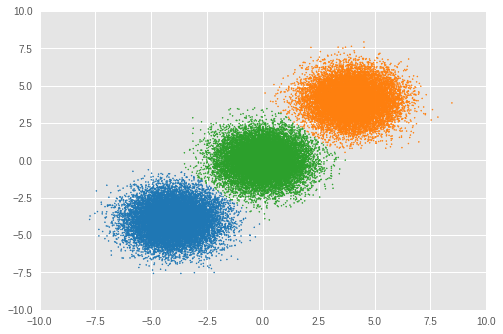

In [ ]:
loc_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='loc_for_posterior')
precision_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='precision_for_posterior')
mix_probs_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num], name='mix_probs_for_posterior')

# Posterior of z (unnormalized)
unnomarlized_posterior = tfd.MultivariateNormalDiag(
    loc=loc_for_posterior, scale_diag=precision_for_posterior)\
   .log_prob(tf.expand_dims(tf.expand_dims(observations, axis=1), axis=1))\
   + tf.log(mix_probs_for_posterior[tf.newaxis, ...])

# Posterior of z (normarizad over latent states)
posterior = unnomarlized_posterior\
  - tf.reduce_logsumexp(unnomarlized_posterior, axis=-1)[..., tf.newaxis]

cluster_asgmt = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: mean_loc_mtx[-sample_size:, :],
        precision_for_posterior: mean_precision_mtx[-sample_size:, :],
        mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]})

idxs, count = np.unique(cluster_asgmt, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_asgmt)))
plt.axis([-10, 10, -10, 10])
plt.show()

我们可以看到几乎相等数量的样本被分配给了合适的簇，并且模型也成功推断出了正确的簇数量。


### 4.2. 呈现不确定度

在这里，我们通过呈现每个样本来查看聚类结果的不确定度。

我们使用熵来计算不确定度：

$$\begin{align*} \text{Uncertainty}*\text{entropy} =  -\frac{1}{K}\sum^{K}*{z_i=1}\sum^{O}_{l=1}p(z_i,|,x_i,,\boldsymbol{\theta}_l)\log p(z_i,|,x_i,,\boldsymbol{\theta}_l) \end{align*}$$

在 pSGLD 中，我们将每次迭代时训练参数的值视为来自其后验分布的样本。因此，我们计算每个参数在 $O$ 迭代值上的熵。通过平均所有簇分配的熵来计算最终的熵值。

In [ ]:
# Calculate entropy
posterior_in_exponential = tf.exp(posterior)
uncertainty_in_entropy = tf.reduce_mean(-tf.reduce_sum(
    posterior_in_exponential
    * posterior,
    axis=1), axis=1)

uncertainty_in_entropy_ = sess.run(uncertainty_in_entropy, feed_dict={
    loc_for_posterior: mean_loc_mtx[-sample_size:, :],
    precision_for_posterior: mean_precision_mtx[-sample_size:, :],
    mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]
})

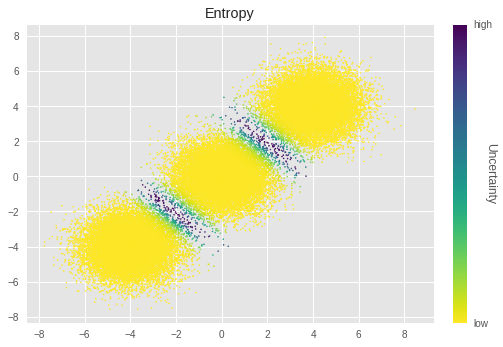

In [ ]:
plt.title('Entropy')
sc = plt.scatter(observations[:, 0],
                 observations[:, 1],
                 1,
                 c=uncertainty_in_entropy_,
                 cmap=plt.cm.viridis_r)
cbar = plt.colorbar(sc,
                    fraction=0.046,
                    pad=0.04,
                    ticks=[uncertainty_in_entropy_.min(),
                           uncertainty_in_entropy_.max()])
cbar.ax.set_yticklabels(['low', 'high'])
cbar.set_label('Uncertainty', rotation=270)
plt.show()

在上图中，亮度越低表示不确定度越高。我们可以看到，簇边界的样本具有特别高的不确定度。这符合直观感受，这些样本很难聚类。

### 4.3. 所选混合分量的平均值和尺度

接下来，我们查看一下所选簇的 $\mu_j$ 和 $\sigma_j$。

In [ ]:
for idx, numbe_of_samples in zip(idxs, count):
  print(
      'Component id = {}, Number of elements = {}'
      .format(idx, numbe_of_samples))
  print(
      'Mean loc = {}, Mean scale = {}\n'
      .format(mean_loc_[idx, :], mean_precision_[idx, :]))

Component id = 0, Number of elements = 16911
Mean loc = [-4.030 -4.113], Mean scale = [ 0.994  0.972]

Component id = 4, Number of elements = 16645
Mean loc = [ 3.999  4.069], Mean scale = [ 1.038  1.046]

Component id = 5, Number of elements = 16444
Mean loc = [-0.005 -0.023], Mean scale = [ 0.967  1.025]



同样，$\boldsymbol{\mu_j}$ 和 $\boldsymbol{\sigma_j}$ 接近基准真相。

### 4.4. 每个混合分量的混合权重

我们也查看一下推断的混合权重。

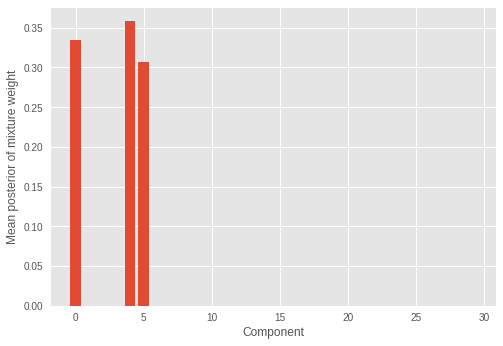

In [ ]:
plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

我们看到只有少数（三个）混合分量具有显著权重，其余的权重值接近于零。这也表明该模型成功推断出了构成样本分布的混合分量的正确数量。

### 4.5. $\alpha$ 的收敛

我们看一下狄利克雷分布的集中度参数 $\alpha$ 的收敛性。

Value of inferred alpha = 0.679



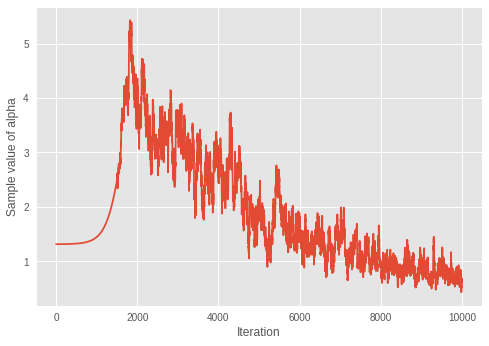

In [ ]:
print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))
plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(mean_alpha_mtx)
plt.show()

考虑到在狄利克雷混合模型中，较小的 $\alpha$ 会导致较少的预期簇数量，该模型似乎在通过迭代学习最佳的簇数量。

### 4.6. 迭代中的推断簇数量

我们来呈现推断的簇数量在迭代中的变化。

为此，我们在迭代中推断簇的数量。

In [ ]:
step = sample_size
num_of_iterations = 50
estimated_num_of_clusters = []
interval = (training_steps - step) // (num_of_iterations - 1)
iterations = np.asarray(range(step, training_steps+1, interval))
for iteration in iterations:
  start_position = iteration-step
  end_position = iteration

  result = sess.run(tf.argmax(
      tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
          loc_for_posterior:
              mean_loc_mtx[start_position:end_position, :],
          precision_for_posterior:
              mean_precision_mtx[start_position:end_position, :],
          mix_probs_for_posterior:
              mean_mix_probs_mtx[start_position:end_position, :]})

  idxs, count = np.unique(result, return_counts=True)
  estimated_num_of_clusters.append(len(count))

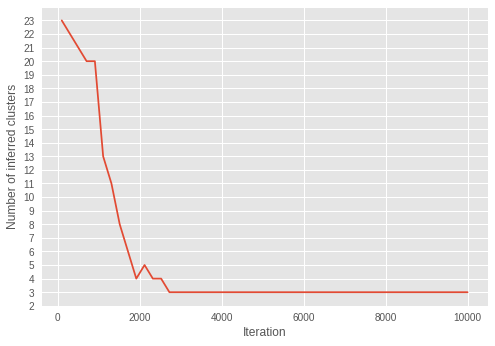

In [ ]:
plt.ylabel('Number of inferred clusters')
plt.xlabel('Iteration')
plt.yticks(np.arange(1, max(estimated_num_of_clusters) + 1, 1))
plt.plot(iterations - 1, estimated_num_of_clusters)
plt.show()

在迭代过程中，簇的数量越来越接近三个。随着 $\alpha$ 在迭代过程中收敛到更小的值，我们可以看到模型在成功学习参数以推断最佳的簇数量。

有趣的是，我们可以看到，推断在早期迭代中已经收敛到正确的簇数量，这与在后期迭代中收敛的 $\alpha$ 不同。


### 4.7. 使用 RMSProp 拟合模型 

在本部分中，为了查看 pSGLD 的蒙特卡洛采样方案的有效性，我们使用 RMSProp 来拟合模型。我们选择 RMSProp 进行比较，因为它没有采样方案，而 pSGLD 基于 RMSProp。


In [ ]:
# Learning rates and decay
starter_learning_rate_rmsprop = 1e-2
end_learning_rate_rmsprop = 1e-4
decay_steps_rmsprop = 1e4

# Number of training steps
training_steps_rmsprop = 50000

# Mini-batch size
batch_size_rmsprop = 20

In [ ]:
# Define trainable variables.
mix_probs_rmsprop = tf.nn.softmax(
    tf.Variable(
        name='mix_probs_rmsprop',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc_rmsprop = tf.Variable(
    name='loc_rmsprop',
    initial_value=np.zeros([max_cluster_num, dims], dtype)
    + np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision_rmsprop = tf.nn.softplus(tf.Variable(
    name='precision_rmsprop',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha_rmsprop = tf.nn.softplus(tf.Variable(
    name='alpha_rmsprop',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals_rmsprop =\
    [mix_probs_rmsprop, alpha_rmsprop, loc_rmsprop, precision_rmsprop]

# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process_rmsprop = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype)
    * alpha_rmsprop / max_cluster_num,
    name='rv_sdp_rmsprop')

rv_loc_rmsprop = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc_rmsprop')


rv_precision_rmsprop = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision_rmsprop')

rv_alpha_rmsprop = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha_rmsprop')

# Define mixture model
rv_observations_rmsprop = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs_rmsprop),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc_rmsprop,
        scale_diag=precision_rmsprop))

In [ ]:
og_prob_parts_rmsprop = [
    rv_loc_rmsprop.log_prob(loc_rmsprop),
    rv_precision_rmsprop.log_prob(precision_rmsprop),
    rv_alpha_rmsprop.log_prob(alpha_rmsprop),
    rv_symmetric_dirichlet_process_rmsprop
        .log_prob(mix_probs_rmsprop)[..., tf.newaxis],
    rv_observations_rmsprop.log_prob(observations_tensor)
    * num_samples / batch_size
]
joint_log_prob_rmsprop = tf.reduce_sum(
    tf.concat(log_prob_parts_rmsprop, axis=-1), axis=-1)

In [ ]:
# Define learning rate scheduling
global_step_rmsprop = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate_rmsprop,
    global_step_rmsprop, decay_steps_rmsprop,
    end_learning_rate_rmsprop, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel_rmsprop = tf.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.99)

train_op_rmsprop = optimizer_kernel_rmsprop.minimize(-joint_log_prob_rmsprop)

init_rmsprop = tf.global_variables_initializer()
sess.run(init_rmsprop)

start = time.time()
for it in range(training_steps_rmsprop):
  [
      _
  ] = sess.run([
      train_op_rmsprop
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_rmsprop = time.time() - start
print("RMSProp elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_rmsprop, training_steps_rmsprop))
print("pSGLD elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_psgld, training_steps))

mix_probs_rmsprop_, alpha_rmsprop_, loc_rmsprop_, precision_rmsprop_ =\
  sess.run(training_vals_rmsprop)

RMSProp elapsed_time: 53.7574200630188 seconds (50000 iterations)
pSGLD elapsed_time: 309.8013095855713 seconds (10000 iterations)


与 pSGLD 相比，虽然 RMSProp 的迭代次数更长，但 RMSProp 的优化速度要快得多。

接下来，我们看一下聚类结果。

Number of inferred clusters = 4

Number of elements in each cluster = [ 1644 15267 16647 16442]



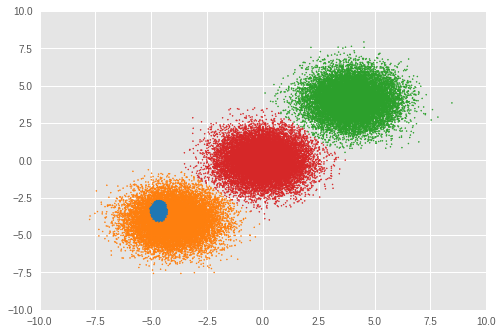

In [ ]:
cluster_asgmt_rmsprop = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: loc_rmsprop_[tf.newaxis, :],
        precision_for_posterior: precision_rmsprop_[tf.newaxis, :],
        mix_probs_for_posterior: mix_probs_rmsprop_[tf.newaxis, :]})

idxs, count = np.unique(cluster_asgmt_rmsprop, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(
        cluster_asgmt_rmsprop)))
plt.axis([-10, 10, -10, 10])
plt.show()

在我们的实验中，RMSProp 优化未正确推断出簇数量。我们也看一下混合权重。

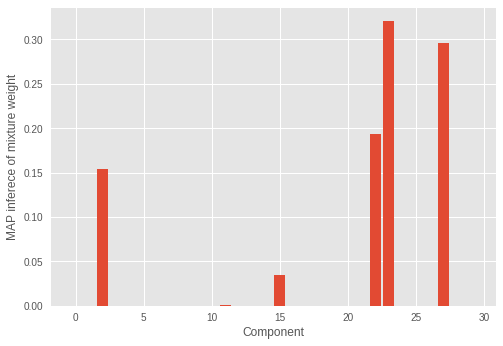

In [ ]:
plt.ylabel('MAP inferece of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mix_probs_rmsprop_)
plt.show()

我们可以看到，具有显著权重的分量的数量不正确。

尽管优化需要更长时间，但具有蒙特卡洛采样方案的 pSGLD 在我们的实验中表现更好。

## 5. 结论

在此笔记本中，我们描述了如何通过使用 pSGLD 拟合高斯分布的狄利克雷过程混合，来对大量样本进行聚类并同时推断簇数量。

实验表明模型成功对样本进行了聚类，并推断出了正确的簇数量。同时，我们展示了 pSGLD 的蒙特卡洛采样方案可以使我们呈现结果的不确定度。我们不仅对样本进行了聚类，还看到了模型可以推断出混合分量的正确参数。关于参数与推断簇数量之间的关系，我们通过呈现 𝛼 的收敛性与推断簇数量的相关性，研究了模型如何学习参数来控制有效簇的数量。最后，我们考察了使用 RMSProp 对模型进行拟合的结果。我们看到 RMSProp（没有蒙特卡洛采样方案的优化器）的工作速度比 pSGLD 快得多，但是生成的聚类准确率较低。

虽然这个小数据集只有 50,000 个样本且只有两个维度，但这里使用的 mini-batch 方式的优化可以扩展到更大的数据集。